In [2]:
from datasets import *
from train import *
from torchvision import datasets, transforms, models

training

In [34]:
model = models.mobilenet_v3_small(weights='DEFAULT').to('cuda')
with torch.no_grad():
    sub_w1 = model.classifier[0].weight[:,:]
    sub_b1 = model.classifier[0].bias[:]
    new_layer1 = torch.nn.Linear(sub_w1.size()[1],1280)

    sub_w2 = model.classifier[3].weight[:,:]
    sub_b2 = model.classifier[3].bias[:]
    new_layer2 = torch.nn.Linear(1280,1000)

    # copy pretrained part of the weight matrix
    new_layer1.weight[:sub_w1.size()[0],:] = sub_w1
    new_layer1.bias[:sub_b1.size()[0]] = sub_b1

    new_layer2.weight[:,:sub_w2.size()[1]] = sub_w2
    new_layer2.bias[:sub_b2.size()[0]] = sub_b2

    model.classifier[0] = new_layer1
    model.classifier[3] = new_layer2
    print(model.classifier)
    # model.classifier[0] = torch.nn.Linear(576,1280)
    # model.classifier[3] = torch.nn.Linear(1280,1000)
# model = models.mobilenet_v3_large()
# model.load_state_dict(torch.load("best_batch_i162153.pth")['model_state_dict'])
# train_loader, val_loader,_ = load_tiny_imagenet(64,1234)
train_loader, val_loader = load_imagenet(64,12345,resize=128)
train(model,train_loader,val_loader,'cuda',lr=0.004)

Sequential(
  (0): Linear(in_features=576, out_features=1280, bias=True)
  (1): Hardswish()
  (2): Dropout(p=0.2, inplace=True)
  (3): Linear(in_features=1280, out_features=1000, bias=True)
)
Train Epoch: 0 [0/1153050 (0%)] train loss: 3.761, lr: 0.00400000
Train Epoch: 0 [51200/1153050 (4%)] train loss: 1.661, lr: 0.00396000
Train Epoch: 0 [102400/1153050 (9%)] train loss: 2.307, lr: 0.00392040
Train Epoch: 0 [153600/1153050 (13%)] train loss: 2.407, lr: 0.00388120
Train Epoch: 0 [204800/1153050 (18%)] train loss: 1.932, lr: 0.00384238
Train Epoch: 0 [256000/1153050 (22%)] train loss: 2.057, lr: 0.00380396
Train Epoch: 0 [307200/1153050 (27%)] train loss: 1.654, lr: 0.00376592
Train Epoch: 0 [358400/1153050 (31%)] train loss: 2.204, lr: 0.00372826
Train Epoch: 0 [409600/1153050 (36%)] train loss: 1.713, lr: 0.00369098
Train Epoch: 0 [460800/1153050 (40%)] train loss: 1.780, lr: 0.00365407
Train Epoch: 0 [512000/1153050 (44%)] train loss: 1.801, lr: 0.00361753
Train Epoch: 0 [563200/11

100%|██████████| 2002/2002 [02:31<00:00, 13.26it/s]


Train Epoch: 0 [468416/1153050 (100%)] train loss: 2.143, val loss: 1.887, val acc: 0.555, top5: 0.791, lr: 0.00317446
==================== best validation accuracy ====================
epoch: 0, val accuracy: 0.5552502790418133
Train Epoch: 1 [0/1153050 (0%)] train loss: 2.061, lr: 0.00317446
Train Epoch: 1 [51200/1153050 (4%)] train loss: 1.490, lr: 0.00157136
Train Epoch: 1 [102400/1153050 (9%)] train loss: 1.473, lr: 0.00155564
Train Epoch: 1 [153600/1153050 (13%)] train loss: 1.279, lr: 0.00154009
Train Epoch: 1 [204800/1153050 (18%)] train loss: 1.567, lr: 0.00152469
Train Epoch: 1 [256000/1153050 (22%)] train loss: 1.320, lr: 0.00150944
Train Epoch: 1 [307200/1153050 (27%)] train loss: 1.413, lr: 0.00149434
Train Epoch: 1 [358400/1153050 (31%)] train loss: 1.461, lr: 0.00147940
Train Epoch: 1 [409600/1153050 (36%)] train loss: 2.039, lr: 0.00146461
Train Epoch: 1 [460800/1153050 (40%)] train loss: 1.464, lr: 0.00144996
Train Epoch: 1 [512000/1153050 (44%)] train loss: 1.625, lr:

100%|██████████| 2002/2002 [02:30<00:00, 13.32it/s]


Train Epoch: 1 [468416/1153050 (100%)] train loss: 1.447, val loss: 1.479, val acc: 0.633, top5: 0.853, lr: 0.00125965
==================== best validation accuracy ====================
epoch: 1, val accuracy: 0.63317124191169
Train Epoch: 2 [0/1153050 (0%)] train loss: 1.316, lr: 0.00125965
Train Epoch: 2 [51200/1153050 (4%)] train loss: 1.186, lr: 0.00062353
Train Epoch: 2 [102400/1153050 (9%)] train loss: 1.017, lr: 0.00061729
Train Epoch: 2 [153600/1153050 (13%)] train loss: 0.915, lr: 0.00061112
Train Epoch: 2 [204800/1153050 (18%)] train loss: 1.367, lr: 0.00060501
Train Epoch: 2 [256000/1153050 (22%)] train loss: 1.346, lr: 0.00059896
Train Epoch: 2 [307200/1153050 (27%)] train loss: 0.936, lr: 0.00059297
Train Epoch: 2 [358400/1153050 (31%)] train loss: 1.351, lr: 0.00058704
Train Epoch: 2 [409600/1153050 (36%)] train loss: 1.056, lr: 0.00058117
Train Epoch: 2 [460800/1153050 (40%)] train loss: 1.366, lr: 0.00057535
Train Epoch: 2 [512000/1153050 (44%)] train loss: 1.634, lr: 0

100%|██████████| 2002/2002 [02:31<00:00, 13.23it/s]

Train Epoch: 2 [468416/1153050 (100%)] train loss: 1.427, val loss: 1.409, val acc: 0.650, top5: 0.862, lr: 0.00049984
==================== best validation accuracy ====================
epoch: 2, val accuracy: 0.650405488732955


Train Epoch: 3 [0/1153050 (0%)] train loss: 1.133, lr: 0.00049984
Train Epoch: 3 [51200/1153050 (4%)] train loss: 1.154, lr: 0.00024742
Train Epoch: 3 [102400/1153050 (9%)] train loss: 1.301, lr: 0.00024495
Train Epoch: 3 [153600/1153050 (13%)] train loss: 1.352, lr: 0.00024250
Train Epoch: 3 [204800/1153050 (18%)] train loss: 1.728, lr: 0.00024007
Train Epoch: 3 [256000/1153050 (22%)] train loss: 0.941, lr: 0.00023767
Train Epoch: 3 [307200/1153050 (27%)] train loss: 0.995, lr: 0.00023529
Train Epoch: 3 [358400/1153050 (31%)] train loss: 0.769, lr: 0.00023294
Train Epoch: 3 [409600/1153050 (36%)] train loss: 1.011, lr: 0.00023061
Train Epoch: 3 [460800/1153050 (40%)] train loss: 1.343, lr: 0.00022830
Train Epoch: 3 [512000/1153050 (44%)] train loss: 1.100, lr: 0.00022602
Train Epoch: 3 [563200/1153050 (49%)] train loss: 1.053, lr: 0.00022376
Train Epoch: 3 [614400/1153050 (53%)] train loss: 1.043, lr: 0.00022152
Train Epoch: 3 [665600/1153050 (58%)] train loss: 0.895, lr: 0.00021931
T

100%|██████████| 2002/2002 [02:32<00:00, 13.09it/s]

Train Epoch: 3 [468416/1153050 (100%)] train loss: 0.900, val loss: 1.363, val acc: 0.659, top5: 0.869, lr: 0.00019834
==================== best validation accuracy ====================
epoch: 3, val accuracy: 0.6590070014127711


Train Epoch: 4 [0/1153050 (0%)] train loss: 1.120, lr: 0.00019834
Train Epoch: 4 [51200/1153050 (4%)] train loss: 1.041, lr: 0.00009818
Train Epoch: 4 [102400/1153050 (9%)] train loss: 0.907, lr: 0.00009720
Train Epoch: 4 [153600/1153050 (13%)] train loss: 0.978, lr: 0.00009622
Train Epoch: 4 [204800/1153050 (18%)] train loss: 1.465, lr: 0.00009526
Train Epoch: 4 [256000/1153050 (22%)] train loss: 1.347, lr: 0.00009431
Train Epoch: 4 [307200/1153050 (27%)] train loss: 0.972, lr: 0.00009337
Train Epoch: 4 [358400/1153050 (31%)] train loss: 1.113, lr: 0.00009243
Train Epoch: 4 [409600/1153050 (36%)] train loss: 0.632, lr: 0.00009151
Train Epoch: 4 [460800/1153050 (40%)] train loss: 1.206, lr: 0.00009059
Train Epoch: 4 [512000/1153050 (44%)] train loss: 1.211, lr: 0.00008969
Train Epoch: 4 [563200/1153050 (49%)] train loss: 0.935, lr: 0.00008879
Train Epoch: 4 [614400/1153050 (53%)] train loss: 1.127, lr: 0.00008790
Train Epoch: 4 [665600/1153050 (58%)] train loss: 0.927, lr: 0.00008702
T

100%|██████████| 2002/2002 [02:34<00:00, 12.98it/s]

Train Epoch: 4 [468416/1153050 (100%)] train loss: 1.251, val loss: 1.351, val acc: 0.661, top5: 0.871, lr: 0.00007870
==================== best validation accuracy ====================
epoch: 4, val accuracy: 0.6610754232459393


Train Epoch: 5 [0/1153050 (0%)] train loss: 1.495, lr: 0.00007870
Train Epoch: 5 [51200/1153050 (4%)] train loss: 1.246, lr: 0.00003896
Train Epoch: 5 [102400/1153050 (9%)] train loss: 1.212, lr: 0.00003857
Train Epoch: 5 [153600/1153050 (13%)] train loss: 0.858, lr: 0.00003818
Train Epoch: 5 [204800/1153050 (18%)] train loss: 1.061, lr: 0.00003780
Train Epoch: 5 [256000/1153050 (22%)] train loss: 1.140, lr: 0.00003742
Train Epoch: 5 [307200/1153050 (27%)] train loss: 1.004, lr: 0.00003705
Train Epoch: 5 [358400/1153050 (31%)] train loss: 1.095, lr: 0.00003668
Train Epoch: 5 [409600/1153050 (36%)] train loss: 0.744, lr: 0.00003631
Train Epoch: 5 [460800/1153050 (40%)] train loss: 1.105, lr: 0.00003595
Train Epoch: 5 [512000/1153050 (44%)] train loss: 1.413, lr: 0.00003559
Train Epoch: 5 [563200/1153050 (49%)] train loss: 1.081, lr: 0.00003523
Train Epoch: 5 [614400/1153050 (53%)] train loss: 1.314, lr: 0.00003488
Train Epoch: 5 [665600/1153050 (58%)] train loss: 0.935, lr: 0.00003453
T

100%|██████████| 2002/2002 [02:32<00:00, 13.13it/s]

Train Epoch: 5 [468416/1153050 (100%)] train loss: 1.303, val loss: 1.351, val acc: 0.662, top5: 0.871, lr: 0.00003123
==================== best validation accuracy ====================
epoch: 5, val accuracy: 0.661707657844002


Train Epoch: 6 [0/1153050 (0%)] train loss: 1.329, lr: 0.00003123
Train Epoch: 6 [51200/1153050 (4%)] train loss: 1.055, lr: 0.00001546
Train Epoch: 6 [102400/1153050 (9%)] train loss: 1.145, lr: 0.00001530
Train Epoch: 6 [153600/1153050 (13%)] train loss: 0.891, lr: 0.00001515
Train Epoch: 6 [204800/1153050 (18%)] train loss: 1.306, lr: 0.00001500
Train Epoch: 6 [256000/1153050 (22%)] train loss: 1.080, lr: 0.00001485
Train Epoch: 6 [307200/1153050 (27%)] train loss: 1.305, lr: 0.00001470
Train Epoch: 6 [358400/1153050 (31%)] train loss: 1.064, lr: 0.00001455
Train Epoch: 6 [409600/1153050 (36%)] train loss: 1.093, lr: 0.00001441
Train Epoch: 6 [460800/1153050 (40%)] train loss: 0.982, lr: 0.00001426
Train Epoch: 6 [512000/1153050 (44%)] train loss: 0.853, lr: 0.00001412
Train Epoch: 6 [563200/1153050 (49%)] train loss: 0.740, lr: 0.00001398
Train Epoch: 6 [614400/1153050 (53%)] train loss: 1.277, lr: 0.00001384
Train Epoch: 6 [665600/1153050 (58%)] train loss: 1.041, lr: 0.00001370
T

100%|██████████| 2002/2002 [02:34<00:00, 12.96it/s]

Train Epoch: 6 [468416/1153050 (100%)] train loss: 1.245, val loss: 1.348, val acc: 0.662, top5: 0.872, lr: 0.00001239
==================== best validation accuracy ====================
epoch: 6, val accuracy: 0.6622774495187992


Train Epoch: 7 [0/1153050 (0%)] train loss: 0.908, lr: 0.00001239
Train Epoch: 7 [51200/1153050 (4%)] train loss: 1.399, lr: 0.00000613
Train Epoch: 7 [102400/1153050 (9%)] train loss: 0.842, lr: 0.00000607
Train Epoch: 7 [153600/1153050 (13%)] train loss: 0.887, lr: 0.00000601
Train Epoch: 7 [204800/1153050 (18%)] train loss: 1.003, lr: 0.00000595
Train Epoch: 7 [256000/1153050 (22%)] train loss: 1.183, lr: 0.00000589
Train Epoch: 7 [307200/1153050 (27%)] train loss: 1.335, lr: 0.00000583
Train Epoch: 7 [358400/1153050 (31%)] train loss: 0.916, lr: 0.00000578
Train Epoch: 7 [409600/1153050 (36%)] train loss: 0.944, lr: 0.00000572
Train Epoch: 7 [460800/1153050 (40%)] train loss: 0.817, lr: 0.00000566
Train Epoch: 7 [512000/1153050 (44%)] train loss: 0.667, lr: 0.00000560
Train Epoch: 7 [563200/1153050 (49%)] train loss: 0.932, lr: 0.00000555
Train Epoch: 7 [614400/1153050 (53%)] train loss: 1.104, lr: 0.00000549
Train Epoch: 7 [665600/1153050 (58%)] train loss: 0.926, lr: 0.00000544
T

100%|██████████| 2002/2002 [02:34<00:00, 12.94it/s]

Train Epoch: 7 [468416/1153050 (100%)] train loss: 0.850, val loss: 1.347, val acc: 0.663, top5: 0.872, lr: 0.00000492
==================== best validation accuracy ====================
epoch: 7, val accuracy: 0.6628862680206374


Train Epoch: 8 [0/1153050 (0%)] train loss: 0.647, lr: 0.00000492
Train Epoch: 8 [51200/1153050 (4%)] train loss: 0.712, lr: 0.00000243
Train Epoch: 8 [102400/1153050 (9%)] train loss: 1.434, lr: 0.00000241
Train Epoch: 8 [153600/1153050 (13%)] train loss: 1.191, lr: 0.00000239
Train Epoch: 8 [204800/1153050 (18%)] train loss: 1.021, lr: 0.00000236
Train Epoch: 8 [256000/1153050 (22%)] train loss: 0.822, lr: 0.00000234
Train Epoch: 8 [307200/1153050 (27%)] train loss: 1.070, lr: 0.00000231
Train Epoch: 8 [358400/1153050 (31%)] train loss: 0.972, lr: 0.00000229
Train Epoch: 8 [409600/1153050 (36%)] train loss: 0.930, lr: 0.00000227
Train Epoch: 8 [460800/1153050 (40%)] train loss: 1.317, lr: 0.00000225
Train Epoch: 8 [512000/1153050 (44%)] train loss: 0.783, lr: 0.00000222
Train Epoch: 8 [563200/1153050 (49%)] train loss: 1.002, lr: 0.00000220
Train Epoch: 8 [614400/1153050 (53%)] train loss: 0.905, lr: 0.00000218
Train Epoch: 8 [665600/1153050 (58%)] train loss: 1.187, lr: 0.00000216
T

100%|██████████| 2002/2002 [02:34<00:00, 12.99it/s]

Train Epoch: 8 [468416/1153050 (100%)] train loss: 1.359, val loss: 1.348, val acc: 0.663, top5: 0.871, lr: 0.00000195
==================== best validation accuracy ====================
epoch: 8, val accuracy: 0.6629331002130865


Train Epoch: 9 [0/1153050 (0%)] train loss: 1.316, lr: 0.00000195


KeyboardInterrupt: 

testing

In [35]:
test_loader = load_imagenet(128,1234,False)
test_loader128 = load_imagenet(128,1234,False,resize=128)

In [36]:
model = models.mobilenet_v3_large(weights='DEFAULT').to('cuda')
model64 = models.mobilenet_v3_small()
model64.classifier[0] = torch.nn.Linear(576,1280)
model64.classifier[3] = torch.nn.Linear(1280,1000)
model64.load_state_dict(torch.load("best_batch_i162153.pth")['model_state_dict'])
model64 = model64.to('cuda')
model.eval()
model64.eval()

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [37]:
acc64_clean = validate(model64,test_loader128,'cuda')

100%|██████████| 391/391 [04:11<00:00,  1.56it/s]


In [38]:
acc64_clean

(0.57538, 1.8619217997621698, 0.80626)

In [9]:
acc_clean = validate(model,test_loader,'cuda')
acc64_clean = validate(model64,test_loader128,'cuda')

100%|██████████| 2002/2002 [02:33<00:00, 13.06it/s]


In [10]:
acc64_clean

(0.41572156700515933, 2.7379780524855963, 0.6734781488795398)

In [8]:
print("Mobilenet V3 Large Clean (224x224)\n Top 1: {:2.2f}%\t Top 5: {:2.2f}%".format(acc_clean[0]*100,acc_clean[2]*100))
print("Mobilenet V3 Large Clean (64x64)\n Top 1: {:2.2f}%\t Top 5: {:2.2f}%".format(acc64_clean[0]*100,acc64_clean[2]*100))

Mobilenet V3 Large Clean (224x224)
 Top 1: 75.31%	 Top 5: 92.63%
Mobilenet V3 Large Clean (64x64)
 Top 1: 38.34%	 Top 5: 63.53%


In [3]:
from thop import profile
model = model = models.mobilenet_v3_large()
input = torch.randn(1, 3, 224, 224)
macs, params = profile(model, inputs=(input, ))
print("224x224:",macs/1e6,params)

model = models.mobilenet_v3_small(weights='DEFAULT')
model.classifier[0] = torch.nn.Linear(576,1280)
model.classifier[3] = torch.nn.Linear(1280,1000)
input = torch.randn(1, 3, 128, 128)
macs, params = profile(model, inputs=(input, ))
print("64x64:",macs/1e6,params)

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
224x224: 234.838456 5483032.0
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.containe

Visualize Embeddings

In [1]:
from datasets import *
from train import *
from torchvision import datasets, transforms, models
from matplotlib.pyplot import figure

In [2]:
model = models.mobilenet_v3_large(weights='DEFAULT').to('cuda')
model64 = models.mobilenet_v3_large()
model64.load_state_dict(torch.load("best_modelsv3/best_batch_i1081020.pth")['model_state_dict'])
model64.to('cuda')
model.eval()
model64.eval()

activationT = {}
activationS = {}
def get_activationT(name):
    def hook(model, input, output):
        activationT[name] = output.detach()
    return hook
def get_activationS(name):
    def hook(model, input, output):
        activationS[name] = output.detach()
    return hook

model.classifier[0].register_forward_hook(get_activationT('emb'))
model64.classifier[0].register_forward_hook(get_activationS('emb'))

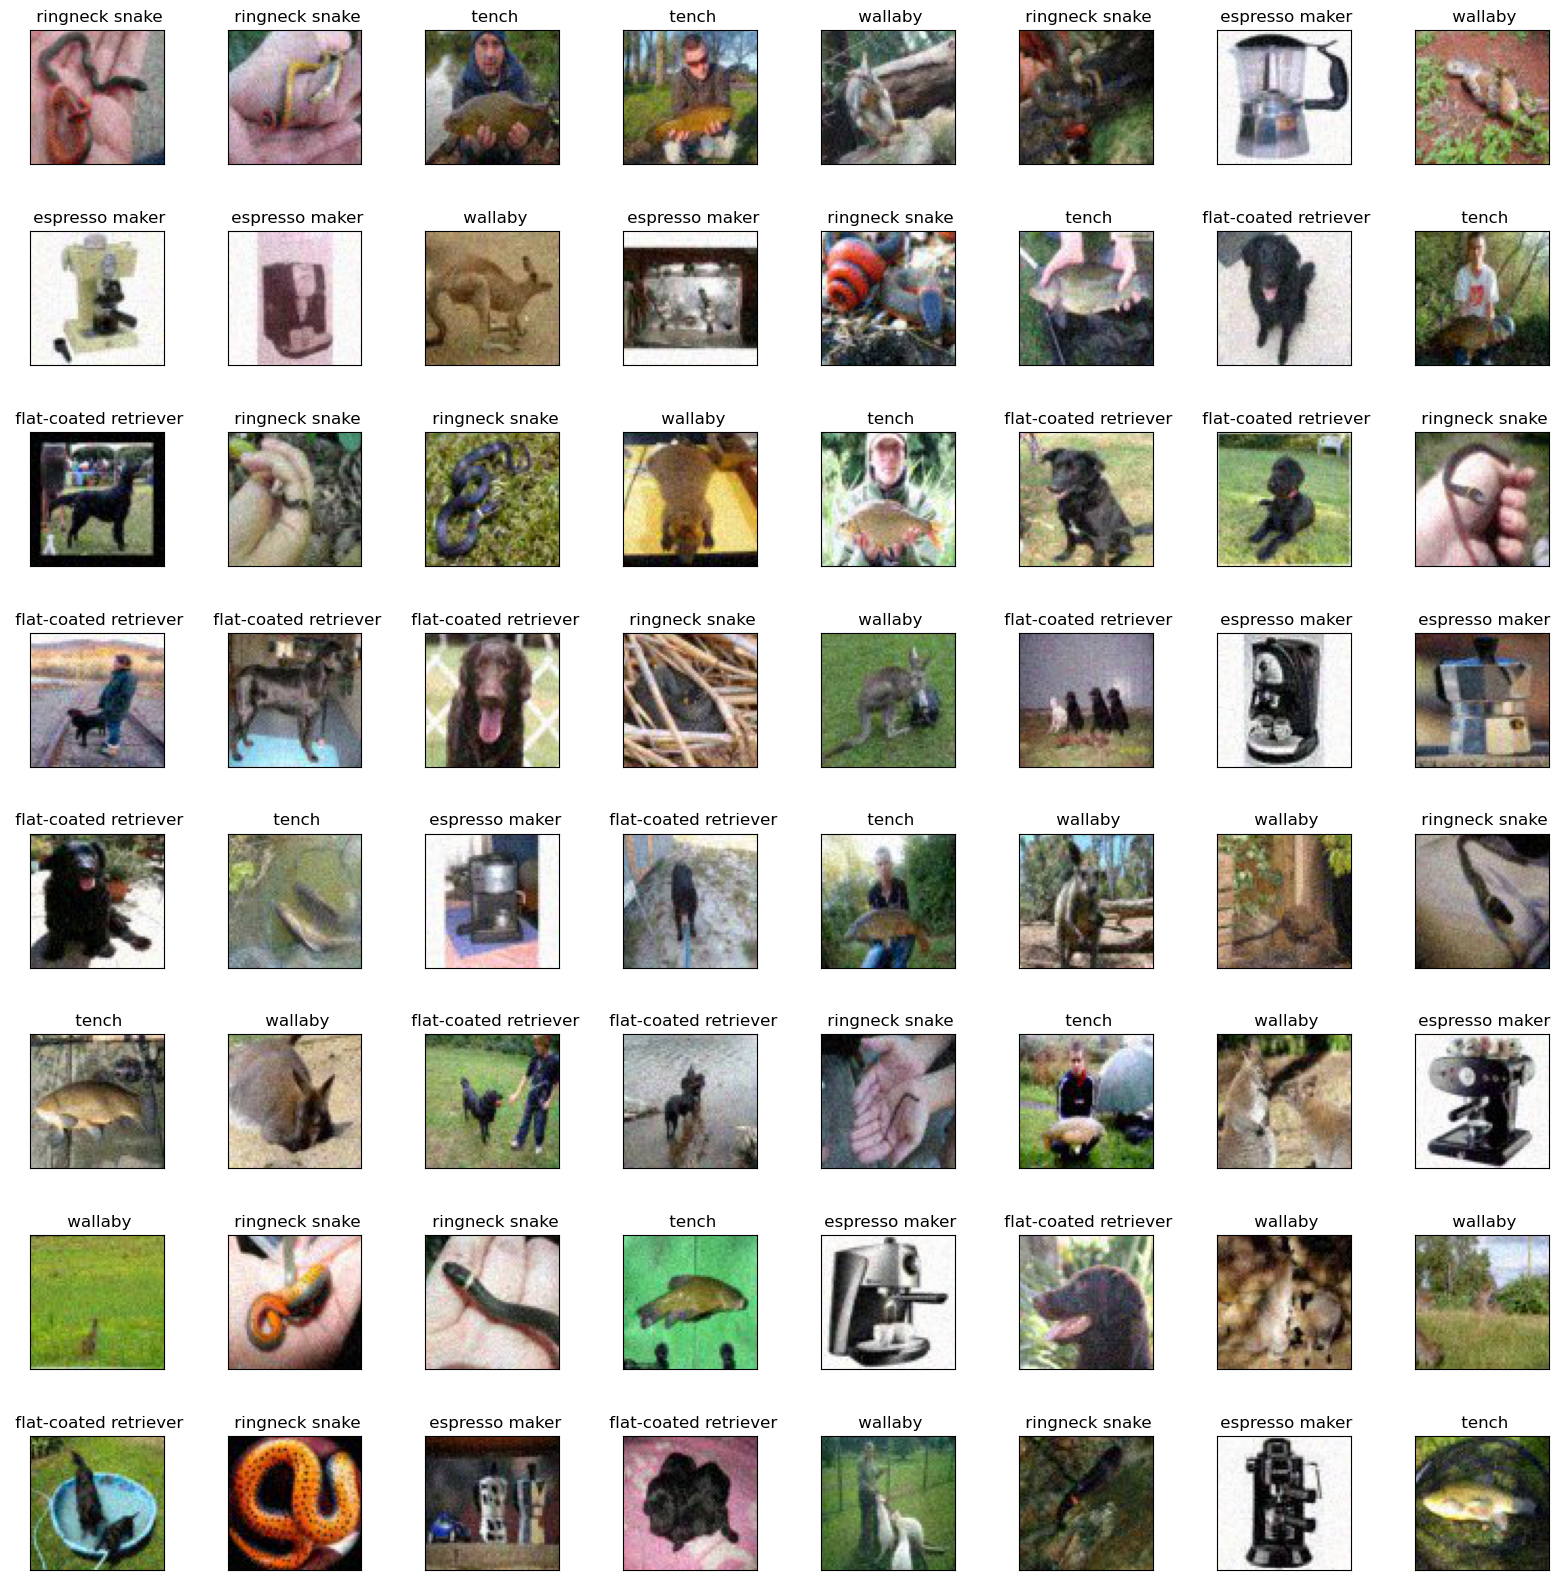

In [6]:
clean_source_loader,_ = load_imagenet(128,1234,True,[0,53,104,205,550])
clean_source_loader64,_ = load_imagenet64(128,1234,True,[0,53,104,205,550])
# visualize_batch(clean_source_loader)

corr_target_loader = load_imagenetc_val(128,1234,class_subset=[0,53,104,205,550],shuffle=True)
corr_target_loader64 = load_imagenetc64_val(128,1234,class_subset=[0,53,104,205,550],shuffle=True)
visualize_batch(corr_target_loader64)

In [4]:
# init tensorboard
writer = SummaryWriter()

batch_imgs, batch_labels = next(iter(clean_source_loader))
preds = model(batch_imgs.to('cuda'))
embds = activationT['emb'].to('cpu')

corr_batch_imgs, corr_batch_labels = next(iter(corr_target_loader))
corr_preds = model(corr_batch_imgs.to('cuda'))
corr_embds = activationT['emb'].to('cpu')

# get the labels
batch_label_strings = []
for idx,label in enumerate(batch_labels):
    batch_label_strings.append(clean_source_loader.dataset.dataset.class_name_map[clean_source_loader.dataset.dataset.class_id_list[label.item()]]+"_CLEAN")

# get the labels
corr_batch_label_strings = []
for idx,label in enumerate(corr_batch_labels):
    corr_batch_label_strings.append(corr_target_loader.dataset.class_name_map[corr_target_loader.dataset.class_id_list[label.item()]]+"_CORR")

batch_imgs = torch.cat((batch_imgs,corr_batch_imgs))
batch_labels = torch.cat((batch_labels,corr_batch_labels))
batch_label_strings.extend(corr_batch_label_strings)
embds = torch.cat((embds,corr_embds))
writer.add_embedding(embds,metadata=batch_label_strings,label_img=batch_imgs)

In [8]:
# init tensorboard
writer = SummaryWriter()

batch_imgs, batch_labels = next(iter(clean_source_loader64))
preds = model64(batch_imgs.to('cuda'))
embds = activationS['emb'].to('cpu')

corr_batch_imgs, corr_batch_labels = next(iter(corr_target_loader64))
corr_preds = model64(corr_batch_imgs.to('cuda'))
corr_embds = activationS['emb'].to('cpu')

# get the labels
batch_label_strings = []
for idx,label in enumerate(batch_labels):
    batch_label_strings.append(clean_source_loader64.dataset.dataset.class_name_map[clean_source_loader64.dataset.dataset.class_id_list[label.item()]]+"_CLEAN")

# get the labels
corr_batch_label_strings = []
for idx,label in enumerate(corr_batch_labels):
    corr_batch_label_strings.append(corr_target_loader64.dataset.class_name_map[corr_target_loader64.dataset.class_id_list[label.item()]]+"_CORR")

batch_imgs = torch.cat((batch_imgs,corr_batch_imgs))
batch_labels = torch.cat((batch_labels,corr_batch_labels))
batch_label_strings.extend(corr_batch_label_strings)
embds = torch.cat((embds,corr_embds))
writer.add_embedding(embds,metadata=batch_label_strings,label_img=batch_imgs)

In [14]:
a = torch.tensor([1,1,1])
b = torch.tensor([[2,2,2],[3,3,3],[4,4,4]])
(b-a).pow(2).sum(dim=1).sqrt().argmin()

tensor(0)

## Domain Shift Direction

Get the class prototypes based on embeddings

In [26]:
batch_imgs, batch_labels = next(iter(clean_source_loader))
corr_batch_imgs, corr_batch_labels = next(iter(corr_target_loader))
cs = [0,53,104,205,550]

# compute prototype based on 15 images
clean_protos = []
corr_protos = []
for c in cs:
    # get the idxs of this class
    idxs = (batch_labels == c).nonzero()[:15].view(-1)
    # get the imgs
    imgs = batch_imgs[idxs]
    # get the embds
    preds = model(imgs.to('cuda'))
    clean_embds = activationT['emb'].to('cpu')
    clean_proto = clean_embds.mean(dim=0)
    clean_protos.append(clean_proto)

    idxs = (corr_batch_labels == c).nonzero()[:15].view(-1)
    imgs = corr_batch_imgs[idxs]
    preds = model(imgs.to('cuda'))
    corr_embds = activationT['emb'].to('cpu')
    corr_proto = corr_embds.mean(dim=0)
    corr_protos.append(corr_proto)
    

In [38]:
# shift angle between clean proto and corr proto for each class
shift_dirs = []
for i,p in enumerate(clean_protos):
    clean_proto = clean_protos[i]
    corr_proto = corr_protos[i]
    shift_dir = corr_proto - clean_proto
    shift_dir = shift_dir/torch.norm(shift_dir)
    shift_dirs.append(shift_dir)

# angle between shift dirs (expected to be zero but no, but all very similar?)
# print(torch.arccos(shift_dirs[0]@shift_dirs[0].T))
print(torch.arccos(shift_dirs[0]@shift_dirs[1].T))
print(torch.arccos(shift_dirs[0]@shift_dirs[2].T))
print(torch.arccos(shift_dirs[0]@shift_dirs[3].T))
print(torch.arccos(shift_dirs[0]@shift_dirs[4].T))
print(torch.arccos(shift_dirs[1]@shift_dirs[2].T))
print(torch.arccos(shift_dirs[1]@shift_dirs[3].T))
print(torch.arccos(shift_dirs[1]@shift_dirs[4].T))
print(torch.arccos(shift_dirs[2]@shift_dirs[3].T))
print(torch.arccos(shift_dirs[2]@shift_dirs[4].T))
print(torch.arccos(shift_dirs[3]@shift_dirs[4].T))
sd = corr_protos[0]-clean_protos[3]
sd = sd/torch.norm(sd)
print(torch.arccos(shift_dirs[0]@sd.T))

tensor(1.3219)
tensor(1.3646)
tensor(1.4478)
tensor(1.4620)
tensor(1.4181)
tensor(1.4679)
tensor(1.4609)
tensor(1.4443)
tensor(1.4452)
tensor(1.4443)
tensor(1.4981)
